<a href="https://colab.research.google.com/github/tkornuta-semiotic/2023-05-AI-workshop/blob/main/notebooks/Image_Recognition_with_HuggingFace_and_ResNet_FineTuning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Image Recognition with PyTorch and ResNet-18

Description: In this tutorial, you will learn how to train an image recognition model using HuggingFace's datasets and models, and monitor training vs validation accuracy to detect overfitting. You will also learn how to fine-tune a pretrained ResNet encoder to achieve faster convergence.

In [ ]:
!pip install torch datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.2 MB/s eta 0:00:00


In [ ]:
# Step 1: Prerequisites.
# 1.1 Import necessary libraries
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import models, transforms
from torchsummary import summary

from datasets import load_dataset
from transformers import AutoTokenizer

In [6]:
# 1.2 Make sure you are using runtime with a GPU.
print(torch.cuda.is_available())

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If True -> we are good to go! :)
# If not:
# -> Go to "Runtime" -> "Change runtime type" -> GPU (or TPU!)
# -> If that won't work - well, we will train on CPU ;)

True


In [7]:
# 1.3 Prepare logs directory.
log_dir = os.path.join(
    "logs",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
os.makedirs(log_dir, exist_ok=True)

In [8]:
# 1.4 Run the TensorBoard.
%load_ext tensorboard
%%tensorboard --logdir log_dir --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


UsageError: Line magic function `%%tensorboard` not found.


# CIFAR-10/CIFAR-100 datasets

CIFAR-10 and CIFAR-100 are two classical image classification datasets that are often used as benchmarks for testing and evaluating computer vision models.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The classes are: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck**. There are 50,000 training images and 10,000 test images.

The CIFAR-100 dataset is similar to CIFAR-10, but with 100 classes, each containing 600 images. The 100 classes are grouped into 20 superclasses, each containing 5 subclasses. The subclasses are highly diverse and include items such as insects, flowers, trees, household appliances, and vehicles.

Both CIFAR-10 and CIFAR-100 are widely used in the research community as standard benchmarks for image classification tasks, due to their relatively small size, ease of use, and availability.



In [ ]:
### Step 2: Load the dataset
# 2.1 Load the whole dataset from HuggingFace's datasets library.
dataset = load_dataset('cifar10')
# Set download_mode='force_redownload' to redownload.

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Step 3: Preprocessing
# 3.1 Change samples in the test set to tensors & pytorch format.

transform = transforms.ToTensor()

test_set = load_dataset('cifar10', split='test[:10%]').map(lambda x: {'img': transform(x['img'])})
test_set = test_set.with_format("pytorch")

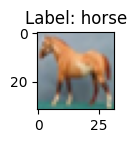

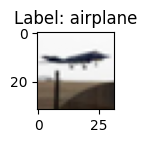

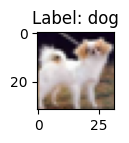

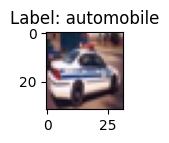

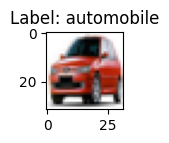

In [ ]:
# 3.2 Visualize some samples from the test split.
# Set CIFAR-10 classes.
cifar10_class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

def imshow(img, title=None):
    plt.figure(figsize=(1, 1))  # Set the figure size to 2 inches by 2 inches
    plt.imshow(np.transpose(img, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

def show_samples(dataset, num_samples=5):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for i in indices:
        sample = dataset[int(i)]
        image = sample['img']
        label = sample['label']
        text_label = cifar10_class_names[label]  # Convert numeric label to text label
        imshow(image, f"Label: {text_label}")

# Show a few random samples from test set.
show_samples(test_set, num_samples=5)

This tutorial will highlight impact of leveraging pretrained image encoders, i.e. features learned by the model on another (bigger) dataset.

In particular, in the second part we will fine-tune ResNet-18 model pretrained on the ImageNet dataset. ImageNet is a large-scale dataset containing more than 14 million images across 20,000 categories. The pretrained models provided by torchvision have been trained on a subset of ImageNet with 1,000 categories and 1.2 million images.

When using a pretrained model, it's important to apply the same preprocessing and normalization that was used during the original pretraining. For the ImageNet dataset, the following normalization is typically used:

In [ ]:
# 3.3 Change samples in the training and validation sets to tensors, and
# additionally apply a typical ImageNet normalization.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Subset of train split - just 5k samples. Remove split to train on the whole subset.
train_set = load_dataset('cifar10', split='train[:5000]').map(lambda x: {'img': transform(x['img'])})
train_set = train_set.with_format("pytorch")#, device=device)

# Validation - in this case we will use 1k samples from test split.
valid_set = load_dataset('cifar10', split='test[:1000]').map(lambda x: {'img': transform(x['img'])})
valid_set = valid_set.with_format("pytorch")#, device=device)     

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Step 4: Create DataLoaders
# 4.1 Set the batch size.
batch_size = 64

# 4.2 Create DataLoaders for the training and validation sets.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# Step 5: Boilerplate training code.
# 5.1 Set up the loss function - cross entropy.
criterion = nn.CrossEntropyLoss()

# 5.2 Define a helper function.
def calculate_accuracy(outputs, labels):
    """ Calculate the accuracy of the model predictions for a batch of inputs. """
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


# 5.3  Define the training loop.
def train_model(model, criterion, optimizer, log_dir, num_epochs=2, n_steps=10):
    """
    Train a PyTorch model using the given loss function and optimizer, and
    log the training process to TensorBoard.

    Args:
        model: A PyTorch model to train.
        criterion: The loss function to use.
        optimizer: The optimizer to use for gradient descent.
        log_dir: The directory where to log the training process for visualization in TensorBoard.
        num_epochs: The number of epochs to train for.
        n_steps: The number of steps (batches) to perform during each epoch.

    Returns:
        None
    """  
    # Create a TensorBoard writer object.
    writer = SummaryWriter(log_dir=log_dir)

    # Reset lists.
    train_accuracies = []
    valid_accuracies = []
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        # Train the model for one epoch
        model.train()

        # "Reset" the running training statistics.
        running_loss = 0.0
        running_acc = 0.0

        for i, data in enumerate(train_loader, 0):
            # Get batch of inputs and targets/labels.
            inputs = data['img'].to(device)
            labels = data['label'].to(device)

            # Reset the gradients.
            optimizer.zero_grad()
            # Forward pass.
            outputs = model(inputs)
            # Calculate loss.
            loss = criterion(outputs, labels)
            # Propagate gradients back.
            loss.backward()
            # Update the model weights using the optimizer and gradients.
            optimizer.step()

            # Update the training statistics.
            running_loss += loss.item() * inputs.size(0)
            running_acc += calculate_accuracy(outputs, labels) * inputs.size(0)
            # Log every n_steps to TensorBoard.
            if (i+1) % n_steps == 0: 
                # Calculate mean values.
                running_loss /= n_steps
                running_acc /= n_steps
                # Append.
                train_losses.append(running_loss)
                train_accuracies.append(running_acc)
                writer.add_scalar('training loss', running_loss, epoch * len(train_loader) + i)
                writer.add_scalar('training accuracy', running_acc, epoch * len(train_loader) + i)
                # "Reset" the running training statistics.
                running_loss = 0.0
                running_acc = 0.0
                # Print the training loss and accuracy for this epoch
                print(f"Epoch {epoch + 1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}")


        # Evaluate the model on the validation set.
        model.eval()
        with torch.no_grad():
            # "Reset" the validation statistics.
            valid_loss = 0.0
            valid_acc = 0.0
            for data in valid_loader:
                # Get batch of inputs and targets/labels.
                inputs = data['img'].to(device)
                labels = data['label'].to(device)

                # Forward pass.
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Update statistics.
                valid_loss += loss.item() * inputs.size(0)
                valid_acc += calculate_accuracy(outputs, labels) * inputs.size(0)

            # Calculate mean values.
            valid_loss /= len(valid_loader.dataset)
            valid_acc /= len(valid_loader.dataset)
            # Append.
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_acc)
            writer.add_scalar('validation loss', valid_loss, (epoch+1) * len(train_loader))
            writer.add_scalar('validation accuracy', valid_acc, (epoch+1) * len(train_loader))


        # Print the training loss and accuracy for this epoch
        print(f"Epoch {epoch + 1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, Valid Loss = {valid_loss:.4f}, Valid Acc = {valid_acc:.4f}")

    writer.close()

### Now we will define and train a few neural network models.

In [ ]:
# Step 6: Define a simple feed-forward model.
# This model has three Fully Connected (FC) layers with ReLU activation between them.
# The input size is 32x32x3 (the dimensions of a CIFAR-10 image),
# and the output size is 10 (the number of classes in CIFAR-10).

class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)  # flatten the input image
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 6.1 Create the model and optimzer - use the basic optimizer (SGD with momentum).
ff_model = CIFAR10Model()
optimizer = optim.SGD(ff_model.parameters(), lr=0.001, momentum=0.9)

# 6.2 Move the models to GPU if available.
ff_model = ff_model.to(device)
# Show model summary.
summary(ff_model, input_size=(3, 32, 32))

# 6.3 Train the model from the scratch and log the data.
train_model(ff_model, criterion, optimizer, os.path.join(log_dir, 'ff_model'))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
            Linear-2                  [-1, 256]         131,328
            Linear-3                   [-1, 10]           2,570
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.51
Estimated Total Size (MB): 6.53
----------------------------------------------------------------
None
Epoch 1: Train Loss = 139.0079, Train Acc = 16.6000, Valid Loss = 2.1239, Valid Acc = 0.2880


In [ ]:
# Step 7: Train a ResNet18 model.

# 7.1 Initialize a new model based on ResNet-18 architecture and set optimizer.
resnet18_model = models.resnet18(num_classes=10)
summary(ff_model, input_size=(3, 32, 32))
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)

# 7.2 Move the models to GPU if available.
resnet18_model = resnet18_model.to(device)

# 7.3 Train the model from the scratch and log the data.
train_model(resnet18_model, criterion, optimizer, os.path.join(log_dir, 'resnet18_model'))


In [ ]:
# Step 8: Fine-tune a model with ResNet18 encoder pretrained on ImageNet.

# 8.1 Initialize a ResNet-18 model pretrained on Imagenet.
pretrained_resnet18_model = models.resnet18(weights=models.resnet.ResNet18_Weights.IMAGENET1K_V1)

# Replace the last FC layer to match the number of classes in your dataset (10 for CIFAR-10).
pretrained_resnet18_model.fc = nn.Linear(pretrained_resnet18_model.fc.in_features, 10)

# Create optimizer.
optimizer = optim.SGD(pretrained_resnet18_model.parameters(), lr=0.001, momentum=0.9)

# 8.2 Move the models to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_resnet18_model = pretrained_resnet18_model.to(device)


# 8.3 Fine-tune the model and log the data.
train_model(pretrained_resnet18_model, criterion, optimizer, os.path.join(log_dir, 'pretrained_resnet18_model'))


In [ ]:
# Stop the Tensorboard - at the end.
%tensorboard --stop